# GarP
In this project I aim to solve a problem that I faced in TÜBİTAK, in refectory when we are putting our tray's we have to throw recycleable things like glass or plastics into correct recycle bins. When someone throw it incorrect bin, it goes like that, it is not effective and bad for our world. 
That's why I will do this project by using what I learned in this internship.

In [13]:
import torch
import torchvision 
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary


### Transform the Data
Apply different techniques to augmentate the data

In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize the image
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Apply random changes to brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image with mean 0.5 and standard deviation 0.5
])

### Reading from Zip

In [15]:
# import zipfile

# temp_dir = 'temp_Garbage_types'

# # Zip dosyasını açma
# with zipfile.ZipFile('Garbage_types.zip', 'r') as zip_ref:
#     zip_ref.extractall(temp_dir)

# # Read the Dataset
# dataset = datasets.ImageFolder(root=temp_dir, transform=transform)


# import shutil

# # After getting the images, clear all directory
# shutil.rmtree(temp_dir)

### Read the dataset from folder

In [16]:
dataset = datasets.ImageFolder(root='Garbage_types', transform=transform)

print(f'Total number of images in dataset: {len(dataset)}')

Total number of images in dataset: 16937


In [17]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')
print(f'Test set size: {len(test_dataset)}')


Training set size: 13549
Validation set size: 1693
Test set size: 1695


In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


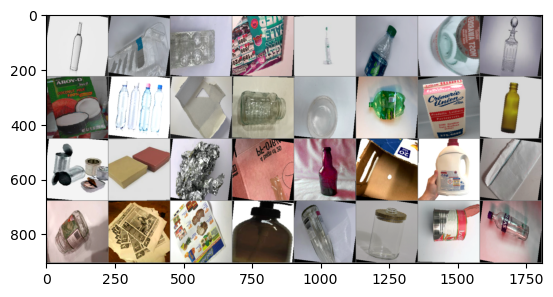

Glass Plastic Plastic Paper Trash Plastic Glass Glass
Cardboard Plastic Paper Glass Plastic Plastic Cardboard Glass
Metal Cardboard Metal Cardboard Glass Cardboard Plastic Paper
Glass Paper Paper Glass Glass Glass Metal Glass


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Sınıf isimlerini almak için
class_names = dataset.classes

def imshow(img):
    img = img / 2 + 0.5  # Normalize işlemini geri al
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Eğitim veri setinden bir batch alalım
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Görüntüleri göster
imshow(torchvision.utils.make_grid(images))

# Sınıf isimlerini yazdır
print('\n'.join(' '.join(f'{class_names[labels[j]]}' for j in range(i, min(i + 8, len(labels)))) for i in range(0, len(labels), 8)))



## This is the model that we used as pretrained

In [20]:
# Upload the pretrained VGG16 model
VGG16_pretrained = models.vgg16(pretrained=True)

# help(summary)

summary(VGG16_pretrained, (3, 224, 224))
print(VGG16_pretrained)

# VGG16_pretrained.features


c:\Users\stajyer\anaconda3\envs\deepakk\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\stajyer\anaconda3\envs\deepakk\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Create Neural Network Structure

In [22]:
# Change the model name 
VGG16_trash_classifier = VGG16_pretrained

# Freeze the pretrained convolutional layers in 'features'
for param in VGG16_trash_classifier.features.parameters():
    param.requires_grad = False

# Mevcut classifier yapısını alıp ilk üç katmanını koruyacağız
classifier_first_part = VGG16_trash_classifier.classifier[:3]

# Kendi ekleyeceğimiz yeni layer'ları tanımlama
additional_layers = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, 6)  # Son katman, 6 sınıf için çıkış
)

# Yeni classifier yapısını oluşturma
trash_classifier = nn.Sequential(
    *classifier_first_part,
    *additional_layers
)

# Replace the classifier in VGG16 model with your 'trash_classifier'
VGG16_trash_classifier.classifier = trash_classifier

# Tüm classifier parametrelerini dondurma
for param in VGG16_trash_classifier.classifier.parameters():
    param.requires_grad = False

# Yalnızca eklediğimiz layer'ları eğitilebilir yapma
for param in VGG16_trash_classifier.classifier[3:].parameters():
    param.requires_grad = True

# Verify the model structure
summary(VGG16_trash_classifier, (3, 224, 224))
print(VGG16_trash_classifier)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Early Stopping

In [23]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=20, min_delta=0.1)

## Train the VGG16_trash_classifier

In [24]:
from tqdm import tqdm  # To visualize the learning process

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(VGG16_trash_classifier.classifier.parameters(), lr=0.001)

num_epochs = 2
best_val_loss = np.inf
best_model_wts = VGG16_trash_classifier.state_dict()

for epoch in range(num_epochs):
    VGG16_trash_classifier.train()
    running_loss = 0.0
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = VGG16_trash_classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Train Loss': running_loss / len(train_loader)})
            pbar.update(1)
    
    avg_train_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss}')

    # Validation loss hesaplama
    VGG16_trash_classifier.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_outputs = VGG16_trash_classifier(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(validation_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss}')

    # Check early stopping
    if early_stopper.early_stop(avg_val_loss):
        print(f'Early stopping at epoch {epoch + 1}')
        n_epoch = epoch + 1
        break

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = VGG16_trash_classifier.state_dict()

print('Finished Training')



Epoch 1/2: 100%|██████████| 424/424 [41:37<00:00,  5.89s/batch, Train Loss=0.795]


Epoch [1/2], Train Loss: 0.7947556670263128
Epoch [1/2], Validation Loss: 0.5660543385541664


Epoch 2/2: 100%|██████████| 424/424 [42:58<00:00,  6.08s/batch, Train Loss=0.603]


Epoch [2/2], Train Loss: 0.6030032332143132
Epoch [2/2], Validation Loss: 0.4817553834532792
Finished Training


## Download the trained model

In [25]:
# Gets the best weights during training
VGG16_trash_classifier.load_state_dict(best_model_wts)

# Save the model
torch.save(VGG16_trash_classifier, 'best_garbage_classifier.pt')

## Upload the model weights
# VGG16_trash_classifier.load_state_dict(torch.load('best_garbage_classifier.pth'))

## Test the VGG16_trash_classifier with Unseen Examples from Dataset

In [26]:
# Modeli test etme
VGG16_trash_classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = VGG16_trash_classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')

Accuracy of the network on the test images: 83.59882005899705%


## Test the Model with Unseen External Images

In [32]:
from PIL import Image

image_path = 'Test/Kagıt.jpg'
image = Image.open(image_path)

image = transform(image).unsqueeze(0)  # Batch boyutunu eklemek için unsqueeze

# Modeli değerlendirme moduna alın
VGG16_trash_classifier.eval()

# Görüntüyü modele verip tahmin edin
with torch.no_grad():
    output = VGG16_trash_classifier(image)
    _, predicted = torch.max(output.data, 1)
    predicted_class = class_names[predicted.item()]

print(f'The model predicts this image as: {predicted_class}')

The model predicts this image as: Paper
